# Hypergraph information

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
import networkx as nx
import xgi
from scipy import linalg
import random
import warnings
warnings.filterwarnings('ignore')

sb.set_theme(style="ticks", context="paper")

# Functions

In [25]:
def construct_hg_multilayer(H):
    """
    Computes the list of Laplacians and the total Laplacian matrix of a hypergraph H.

    Parameters
    ----------
    H : xgi.Hypergraph
        The hypergraph to compute the Laplacian of

    Returns
    -------
    list: a list of Laplacians, ordered by their order
    np.ndarray: the total Laplacian matrix
    """
    max_d = xgi.max_edge_order(H)
    hg_m = []
    for d in range(1, max_d + 1):
        L = xgi.laplacian(H, d, rescale_per_node=False)
        hg_m.append(L)
    N = H.num_nodes
    hg_all = np.zeros((N, N))
    for l in range(len(hg_m)):
        hg_all = hg_all + hg_m[l]
    return hg_m, hg_all


def density(Lap, tau):
    """
    Computes the density matrix for a Laplacian with scale `tau`.

    Parameters
    ----------
    Lap : np.ndarray
        The Laplacian matrix
    tau : float
        The scale of the Laplacian

    Returns
    -------
    np.ndarray: the density matrix
    """
    rho = linalg.expm(-tau * Lap)
    rho = rho / np.trace(rho) + np.eye(len(rho)) * 10**-10
    return rho

def entropy(L, tau):
    """
    Computes the entropy associated to the Laplacian matrix.

    Parameters
    ----------
    L: numpy.ndarray
        The Laplacian matrix
    tau: float
        The scale of signal propagation

    Returns
    -------
    S: float
        The entropy of the graph
    """
    Ls = np.linalg.eigvals(L)  # Calculate eigenvalues of L
    Z = np.sum(np.exp(-tau * Ls))  # Calculates the partition function
    p = np.exp(-tau * Ls) / Z  # Calculates the probabilities
    p = np.delete(p,np.where(p<10**-8))
    S = np.sum(-p * np.log(p))  # entropy
    return S


def KL(rho_emp, rho_model):
    """
    Computes the Kullback-Leibler (KL) divergence between an empirical observation `rho_emp` and a model `rho_model`.

    Parameters
    ----------
    rho_emp : (np.ndarray)
        The empirical observation
    rho_model : np.ndarray
        The model

    Returns
    -------
    float: the KL divergence between `rho_emp` and `rho_model`
    """
    
    return (np.trace( np.matmul(rho_emp, linalg.logm(rho_emp)) 
                     - np.matmul(rho_emp, linalg.logm(rho_model))))
            
def penalization(Lap, tau):
    """
    Computes the partition function of a Laplacian with scale `tau`.

    Parameters
    ----------
    Lap : np.ndarray
        The Laplacian matrix
    tau : float
        The scale of the Laplacian

    Returns
    -------
    float: the partition function
    """
    Z = np.trace(linalg.expm(- tau * Lap))
    N = len(Lap)
    return np.log(N) - entropy(Lap,tau)


def optimization(H, tau):
    """
    Computes the gain and loss for modeling a hypergraph (up to order `d_max`),
    using a part of it, up to order `d < d_max`.

    Parameters
    ----------
    H: xgi Hypergraph
        The input hypergraph
    tau: float
        The scale of signal propagation

    Returns
    -------
    D: numpy.ndarray
        The learning error
    lZ: numpy.ndarray
        The penalization term for model complexity
    """
    """
    
    
    hg_m, hg_all = construct_hg_multilayer(H)
    rho_all = density(hg_all, tau)

    
    """
    
    orders = np.array(xgi.unique_edge_sizes(H)) - 1
    weights = np.ones(len(orders))
    L_multi = xgi.multiorder_laplacian(H, orders, weights, rescale_per_node=False)
    
    rho_all = density(L_multi, tau)
    
    D = []
    lZ = []
    N = H.num_nodes
    
    for l in range(len(orders)):
        L_l = xgi.multiorder_laplacian(H, orders[0:l+1], weights[0:l+1], rescale_per_node=False)
        rho_l = density(L_l, tau)
        d = KL(rho_all, rho_l)
        z = penalization(L_l,tau)
        
        D.append(d)   
        lZ.append(z)

    lZ = np.array(lZ)  ### Penalization term for model complexity
    D = np.array(D)  ### Learning error

    return D, lZ


def compute_information(H, tau):
    """
    Utility function to compute the information of the hypergraph.

    Parameters
    ----------
    H: nx.Graph
        The input hypergraph
    taus: list of float
        The scale of signal propagation

    Returns
    -------
    Ds: numpy.ndarray
        The learning errors
    lZs: numpy.ndarray
        The penalization terms for model complexity
    orders: list
        The orders of the hypergraph
    """
    #n_t = len(taus)
    orders = np.array(xgi.unique_edge_sizes(H)) - 1
    d_max=len(orders)
    #Ds = np.zeros((n_t, d_max))
    #lZs = np.zeros((n_t, d_max))

    Ds = np.zeros(d_max)
    lZs = np.zeros(d_max)
    
    #for tau in tqdm(taus):
    Ds, lZs = optimization(H, tau)
    #for i, tau in enumerate(tqdm(taus)):
    #    Ds[i, :], lZs[i, :] = optimization(H, tau)
    
    return Ds, lZs, orders


def plot_information(H, taus, axs=None, label=None):
    """
    Plot information function

    Parameters
    ----------
    H : xgi  hypergraph
        The hypergraph to be plotted
    taus : list of float
        The values of tau to plot
    axs : list of matplotlib axes, optional
        The list of matplotlib axes to plot the information function, by default None
    label : str, optional
        The label for the plot, by default None

    Returns
    -------
    tuple of matplotlib figure and list of matplotlib axes
        The matplotlib figure and the list of matplotlib axes used to plot the information function
    """
    if axs is None:
        fig, axs = plt.subplots(
            1, len(taus), figsize=(2 * len(taus), 2.1), constrained_layout=True
        )

    d_max = xgi.max_edge_order(H)
    orders = range(1, d_max + 1)

    for i, tau in enumerate(taus):

        D, lZ = optimization(H, tau)

        axs[i].plot(orders, lZ - D, "o-", label=label)

        axs[i].set_title(rf"$\tau = {tau}$", weight="bold")
        axs[i].set_xlabel("Max order")
        axs[i].set_xticks(orders)

    axs[0].set_ylabel("Quality function")

    sb.despine()

    return plt.gcf(), axs


def shuffle_hyperedges(S, order, p):
    """Shuffle existing hyperdeges of order d with probablity p
    Parameters
    ----------
    S: xgi.HyperGraph
            Hypergraph
    order: int
            Order of hyperedges to shuffle
    p: float
            Probability of shuffling each hyperedge
    Returns
    -------
    H: xgi.HyperGraph
            Hypergraph with edges of order d shuffled
    """

    nodes = S.nodes
    H = xgi.Hypergraph(S)

    d_hyperedges = H.edges.filterby("order", order).members(dtype=dict)

    for id_, members in d_hyperedges.items():
        if random.random() <= p:
            H.remove_edge(id_)
            new_hyperedge = tuple(random.sample(nodes, order + 1))
            while new_hyperedge in H._edge.values():
                new_hyperedge = tuple(random.sample(nodes, order + 1))
            H.add_edge(new_hyperedge)

    assert H.num_nodes == S.num_nodes
    assert xgi.num_edges_order(H, 1) == xgi.num_edges_order(S, 1)
    assert xgi.num_edges_order(H, 2) == xgi.num_edges_order(S, 2)

    return H


## hypergraph datasets

In [6]:
#import tqdm

data_names = [
    "email-enron",
    "hospital-lyon",
    "diseasome",
]

HGs = {}
for name in tqdm(data_names): 
    HGs[name] = xgi.load_xgi_data(name, max_order=None, cache=True)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


### Data

In [86]:
i = 1 # choose dataset here
name = data_names[i]
print(name)
H0 = HGs[name]
print(H0)
print("max order:", xgi.max_edge_order(H0))
H0.cleanup(isolates=True)
print(H0)
orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

hospital-lyon
Hypergraph named hospital-Lyon with 75 nodes and 2945 hyperedges
max order: 9
Hypergraph named hospital-Lyon with 75 nodes and 2945 hyperedges


## Choose the characteristic $\tau_{c}$

In [87]:
L_multi = xgi.multiorder_laplacian(H0, orders, weights, rescale_per_node=False)
Ls = np.sort(np.linalg.eigvals(L_multi))
tau_c = 1/Ls[-1]

## The curves

#### 1) Ds_H is the information loss, KL divergence between model and data (full hypergraph) --- $KL(data|model)$

#### 2) lZs_H is the penalization term encoding complexity of model in terms of bits --- $S_{iso} - S_{model}$

#### 3) Q is the quality function, to minimize information loss and model complexity, at the same time

In [88]:
Ds_H, lZs_H, orders = compute_information(H0, tau_c)
Q = Ds_H + lZs_H

## Figure 1

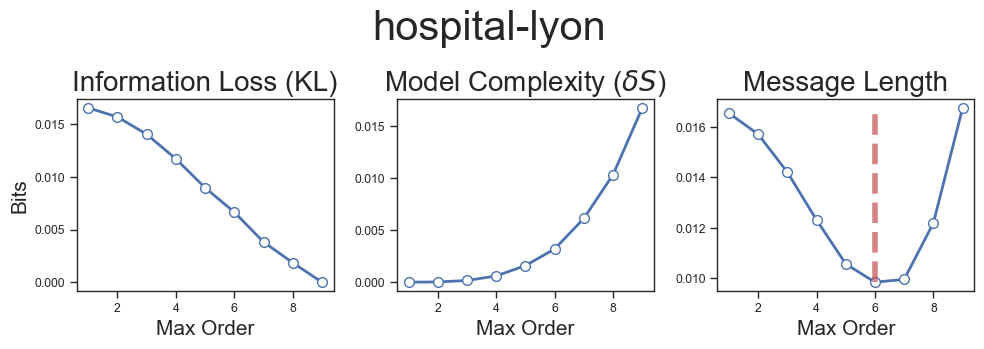

In [89]:
f = 20
plt.figure(figsize=[10,3.5],layout='tight')
plt.suptitle(name,fontsize=f+10)
plt.subplot(1,3,1)
plt.title('Information Loss (KL)',fontsize=f)
plt.xlabel('Max Order',fontsize=f-5)
plt.ylabel('Bits',fontsize=f-5)
plt.plot(orders,Ds_H,"o-", ms=7, mfc="w",linewidth=2)
plt.subplot(1,3,2)
plt.title('Model Complexity ($\delta S$)',fontsize=f)
plt.xlabel('Max Order',fontsize=f-5)
plt.plot(orders,lZs_H,"o-", ms=7, mfc="w",linewidth=2)
plt.subplot(1,3,3)
plt.title('Message Length',fontsize=f)
plt.xlabel('Max Order',fontsize=f-5)
plt.plot(orders,Q,"o-", ms=7, mfc="w",linewidth=2)
y=np.where(Q==min(Q))*np.ones(len(Q))+1
plt.plot(y[0],np.linspace(np.min(Q),np.max(Q),len(Q)),color='r',linewidth=4, alpha=.7, linestyle='dashed')
plt.savefig('C:\\Users\\User\\Desktop\\Fig1.pdf', bbox_inches="tight",dpi=300,format='pdf')